In [2]:
%cd /capstor/scratch/cscs/ckuya/


/capstor/scratch/cscs/ckuya


In [4]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import os
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import os
import numpy as np
import librosa
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import os
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

## Dataloader

In [5]:
class AudioFeatureDataset(Dataset):
    def __init__(self, root_dir,
                 sr=16000,
                 n_fft=2048,
                 hop_percent=0.0,
                 win_length=320,
                 n_mels=40,
                 n_mfcc=13,
                 max_len=None,
                 exclude_folders=None):
        """
        root_dir:  top‐level folder containing one subfolder per class
        max_len:   maximum time‐frames to pad/truncate to
        exclude_folders: list of subfolders to skip (e.g. ['_background_noise_'])
        """
        super().__init__()
        self.root_dir       = root_dir
        self.sr             = sr
        self.n_fft          = n_fft
        self.win_length     = win_length
        self.hop_length     = int(win_length * (1-hop_percent))
        self.n_mels         = n_mels
        self.n_mfcc         = n_mfcc
        self.max_len        = max_len
        self.exclude_folders= set(exclude_folders or [])

        self._prepare_dataset()

    def _prepare_dataset(self):
        # 1) find all subfolders (classes), filter excludes
        labels = sorted([
            d for d in os.listdir(self.root_dir)
            if os.path.isdir(os.path.join(self.root_dir, d))
               and d not in self.exclude_folders
        ])
        # 2) build label→index map
        self.label_to_idx = {lab: idx for idx, lab in enumerate(labels)}

        # 3) walk filesystem
        self.samples = []
        for lab in labels:
            folder = os.path.join(self.root_dir, lab)
            for fn in os.listdir(folder):
                if fn.lower().endswith(('.wav','.mp3')):
                    self.samples.append((os.path.join(folder, fn),
                                         self.label_to_idx[lab]))

        # 4) sanity
        N = len(self.label_to_idx)
        self.samples = [s for s in self.samples if 0 <= s[1] < N]
        print(f"[Dataset] Found {len(self.samples)} files "
              f"under {N} classes: {labels}")

    def __len__(self):
        return len(self.samples)

    def _extract_features(self, path):
        y, _ = librosa.load(path, sr=self.sr)
        # Mel-spectrogram
        m = librosa.feature.melspectrogram(
            y=y, sr=self.sr,
            n_fft=self.n_fft,
            hop_length=self.hop_length,
            win_length=self.win_length,
            n_mels=self.n_mels)
        log_mel = librosa.power_to_db(m)
        # MFCC
        mfcc = librosa.feature.mfcc(
            y=y, sr=self.sr,
            n_mfcc=self.n_mfcc,
            n_fft=self.n_fft,
            hop_length=self.hop_length,
            win_length=self.win_length)
        # normalize
        log_mel = (log_mel - log_mel.mean()) / (log_mel.std() + 1e-8)
        mfcc    = (mfcc    - mfcc.mean())    / (mfcc.std()    + 1e-8)
        # pad / truncate in time
        if self.max_len is not None:
            T = log_mel.shape[1]
            if T >= self.max_len:
                log_mel = log_mel[:, :self.max_len]
                mfcc    = mfcc   [:, :self.max_len]
            else:
                pw = self.max_len - T
                log_mel = np.pad(log_mel, ((0,0),(0,pw)), mode='constant')
                mfcc    = np.pad(mfcc,    ((0,0),(0,pw)), mode='constant')
        return log_mel, mfcc

    def __getitem__(self, idx):
        path, lab = self.samples[idx]
        log_mel, mfcc = self._extract_features(path)
        return {
            'mel':   torch.FloatTensor(log_mel),   # (n_mels, T)
            'mfcc':  torch.FloatTensor(mfcc),      # (n_mfcc, T)
            'label': torch.LongTensor([lab]).squeeze()
        }

def get_dataloaders(root_dir,
                    mel_dim     = 40,
                    mfcc_dim    = 13,
                    max_len     = 20,
                    batch_size  = 256,
                    val_frac    = 0.2,
                    num_workers = 4,
                    exclude_folders = ['_background_noise_']):
    """
    Returns: train_loader, val_loader, num_classes, label_to_idx
    """
    ds = AudioFeatureDataset(
        root_dir        = root_dir,
        n_mels          = mel_dim,
        n_mfcc          = mfcc_dim,
        max_len         = max_len,
        exclude_folders = exclude_folders
    )
    num_classes = len(ds.label_to_idx)
    n_val  = int(len(ds) * val_frac)
    n_train= len(ds) - n_val
    train_ds, val_ds = random_split(ds, [n_train, n_val])
    train_loader = DataLoader(
        train_ds, batch_size=batch_size,
        shuffle=True,  num_workers=num_workers, pin_memory=True)
    val_loader   = DataLoader(
        val_ds,   batch_size=batch_size,
        shuffle=False, num_workers=num_workers, pin_memory=True)
    return train_loader, val_loader, num_classes, ds.label_to_idx


## Model 

In [6]:
class MelCNN(nn.Module):
    def __init__(self, num_classes):
        super(MelCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),  # (B, 1, 40, 20) → (B, 16, 40, 20)
            nn.ReLU(),
            nn.MaxPool2d(2),                            # (B, 16, 20, 10)

            nn.Conv2d(16, 32, kernel_size=3, padding=1), # (B, 32, 20, 10)
            nn.ReLU(),
            nn.MaxPool2d(2),                             # (B, 32, 10, 5)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),                                # (B, 32*10*5)
            nn.Linear(32 * 10 * 5, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.classifier(x)
        return x

class SbuLSTMClassifier(nn.Module):
    def __init__(self,
                 n_mels: int            = 40,
                 hidden_dim: int        = 128,
                 uni_layers: int        = 1,
                 num_classes: int       = 30,
                 dropout: float         = 0.3):
        super(SbuLSTMClassifier, self).__init__()
        # 1) Bidirectional LSTM feature extractor
        self.bdlstm = nn.LSTM(
            input_size   = n_mels,
            hidden_size  = hidden_dim,
            num_layers   = 1,
            batch_first  = True,
            bidirectional= True
        )
        # 2) Unidirectional LSTM for forward‐only refinement
        self.lstm = nn.LSTM(
            input_size  = 2 * hidden_dim,
            hidden_size = hidden_dim,
            num_layers  = uni_layers,
            batch_first = True,
            bidirectional = False
        )
        # 3) MLP classifier on the last time step
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, 64),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(64, num_classes)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: (B, 1, n_mels, T)
        B, C, F, T = x.shape
        # remove channel dim → (B, F, T), then time‐first → (B, T, F)
        x = x.view(B, F, T).permute(0, 2, 1)

        # 1) Bidirectional LSTM → (B, T, 2*hidden_dim)
        x, _ = self.bdlstm(x)

        # 2) Unidirectional LSTM → (B, T, hidden_dim)
        x, _ = self.lstm(x)

        # 3) Take last time step features
        last = x[:, -1, :]              # (B, hidden_dim)

        # 4) Classify
        logits = self.classifier(last)  # (B, num_classes)
        return logits

class SbuLSTMFusion(nn.Module):
    def __init__(self,
                 n_mels: int       = 40,
                 n_mfcc: int       = 13,
                 hidden_dim: int   = 128,
                 uni_layers: int   = 1,
                 num_classes: int  = 30,
                 dropout: float    = 0.3):
        super().__init__()
        # Bi-LSTM on Mel
        self.bdlstm_mel = nn.LSTM(
            input_size    = n_mels,
            hidden_size   = hidden_dim,
            num_layers    = 1,
            batch_first   = True,
            bidirectional = True
        )
        # Bi-LSTM on MFCC
        self.bdlstm_mfcc = nn.LSTM(
            input_size    = n_mfcc,
            hidden_size   = hidden_dim,
            num_layers    = 1,
            batch_first   = True,
            bidirectional = True
        )
        # Unidirectional LSTM after fusion
        fused_dim = 2*hidden_dim*2   # mel(2h) + mfcc(2h)
        self.lstm = nn.LSTM(
            input_size  = fused_dim,
            hidden_size = hidden_dim,
            num_layers  = uni_layers,
            batch_first = True
        )
        # Classifier MLP
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, 64),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(64, num_classes)
        )

    def forward(self, mel: torch.Tensor, mfcc: torch.Tensor) -> torch.Tensor:
        # mel: (B,1,n_mels,T), mfcc: (B,1,n_mfcc,T)
        B,_,F_mel,T = mel.shape
        _,_,F_mfcc,_= mfcc.shape

        # → (B, T, F)
        mel = mel.view(B, F_mel, T).permute(0,2,1)
        mf  = mfcc.view(B, F_mfcc, T).permute(0,2,1)

        # Bi-LSTM branches
        mel_feats, _ = self.bdlstm_mel(mel)   # (B,T,2*hidden)
        mf_feats,  _ = self.bdlstm_mfcc(mf)  # (B,T,2*hidden)

        # fuse
        x = torch.cat([mel_feats, mf_feats], dim=2)  # (B,T,4*hidden)

        # uni-LSTM
        x, _ = self.lstm(x)                          # (B,T,hidden)

        # classify last timestep
        logits = self.classifier(x[:, -1, :])        # (B,num_classes)
        return logits



## Training

In [ ]:
# make sure CUDA errors sync
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

# from dataloader import get_dataloaders
# from models      import SbuLSTMFusion

def main():
    # hyper‐params
    root_dir      = '/capstor/scratch/cscs/ckuya/speech-data/train/audio/'
    mel_dim       = 40
    mfcc_dim      = 13
    max_len       = 20
    batch_size    = 256
    val_frac      = 0.2
    epochs        = 50
    lr            = 1e-3
    weight_decay  = 1e-5
    step_size     = 3
    gamma         = 0.5
    hidden_dim    = 128
    uni_layers    = 1
    dropout       = 0.3
    num_workers   = 4
    exclude_folders = []

    # 1) Data
    train_loader, val_loader, num_classes, label_map = get_dataloaders(
        root_dir        = root_dir,
        mel_dim         = mel_dim,
        mfcc_dim        = mfcc_dim,
        max_len         = max_len,
        batch_size      = batch_size,
        val_frac        = val_frac,
        num_workers     = num_workers,
        exclude_folders = exclude_folders
    )
    print(f"Classes ({num_classes}): {list(label_map.keys())}")

    # 2) Model / Optim / Scheduler / Loss
    device   = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model    = SbuLSTMFusion(
        n_mels     = mel_dim,
        n_mfcc     = mfcc_dim,
        hidden_dim = hidden_dim,
        uni_layers = uni_layers,
        num_classes= num_classes,
        dropout    = dropout
    ).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(
        model.parameters(),
        lr=lr,
        weight_decay=weight_decay
    )
    scheduler = optim.lr_scheduler.StepLR(
        optimizer,
        step_size=step_size,
        gamma=gamma
    )

    # 3) Train + Validate
    best_val_acc = 0.0
    for epoch in range(1, epochs+1):
        # ——— TRAIN ———
        model.train()
        running_loss = 0.0
        correct = 0
        total   = 0
        for batch in tqdm(train_loader, desc=f"Train {epoch}/{epochs}"):
            mel   = batch['mel'].unsqueeze(1).to(device)
            mfcc  = batch['mfcc'].unsqueeze(1).to(device)
            labels= batch['label'].to(device)

            logits = model(mel, mfcc)
            loss   = criterion(logits, labels)

            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            optimizer.step()

            running_loss += loss.item() * labels.size(0)
            preds = logits.argmax(dim=1)
            correct += (preds==labels).sum().item()
            total   += labels.size(0)

        scheduler.step()
        train_loss = running_loss/total
        train_acc  = 100*correct/total

        # ——— VALIDATE ———
        model.eval()
        val_loss = 0.0
        val_corr = 0
        val_tot  = 0
        with torch.no_grad():
            for batch in val_loader:
                mel   = batch['mel'].unsqueeze(1).to(device)
                mfcc  = batch['mfcc'].unsqueeze(1).to(device)
                labels= batch['label'].to(device)

                logits = model(mel, mfcc)
                loss   = criterion(logits, labels)
                val_loss += loss.item() * labels.size(0)

                preds = logits.argmax(dim=1)
                val_corr += (preds==labels).sum().item()
                val_tot  += labels.size(0)

        val_loss /= val_tot
        val_acc   = 100*val_corr/val_tot

        print(f"Epoch {epoch}: "
              f"Train Loss={train_loss:.4f}, Acc={train_acc:.2f}% | "
              f"Val   Loss={val_loss:.4f}, Acc={val_acc:.2f}%")

        # save best
        if val_acc>best_val_acc:
            torch.save(model.state_dict(),"best_sbulstm_fusion1.pth")
            best_val_acc=val_acc

    print(f"Training done → Best Val Acc: {best_val_acc:.2f}%")

if __name__=="__main__":
    main()


[Dataset] Found 64727 files under 31 classes: ['_background_noise_', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'four', 'go', 'happy', 'house', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'wow', 'yes', 'zero']
Classes (31): ['_background_noise_', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'four', 'go', 'happy', 'house', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'wow', 'yes', 'zero']


Train 1/50: 100%|██████████| 203/203 [03:59<00:00,  1.18s/it]


Epoch 1: Train Loss=2.8373, Acc=16.74% | Val   Loss=2.3371, Acc=30.93%


Train 2/50: 100%|██████████| 203/203 [00:53<00:00,  3.79it/s]


Epoch 2: Train Loss=2.2568, Acc=33.67% | Val   Loss=2.0491, Acc=40.83%


Train 3/50: 100%|██████████| 203/203 [00:55<00:00,  3.68it/s]


Epoch 3: Train Loss=2.0298, Acc=41.06% | Val   Loss=1.8806, Acc=45.32%


Train 4/50: 100%|██████████| 203/203 [00:54<00:00,  3.75it/s]


Epoch 4: Train Loss=1.8763, Acc=45.69% | Val   Loss=1.8161, Acc=47.46%


Train 5/50: 100%|██████████| 203/203 [00:52<00:00,  3.87it/s]


Epoch 5: Train Loss=1.8154, Acc=47.68% | Val   Loss=1.7659, Acc=48.27%


Train 6/50: 100%|██████████| 203/203 [00:50<00:00,  4.05it/s]


Epoch 6: Train Loss=1.7716, Acc=48.71% | Val   Loss=1.7225, Acc=49.56%


Train 7/50: 100%|██████████| 203/203 [00:49<00:00,  4.08it/s]


Epoch 7: Train Loss=1.7053, Acc=50.63% | Val   Loss=1.7004, Acc=50.41%


Train 8/50: 100%|██████████| 203/203 [00:48<00:00,  4.22it/s]


Epoch 8: Train Loss=1.6819, Acc=51.42% | Val   Loss=1.6942, Acc=50.58%


Train 9/50: 100%|██████████| 203/203 [00:49<00:00,  4.09it/s]


Epoch 9: Train Loss=1.6636, Acc=51.70% | Val   Loss=1.6845, Acc=50.78%


Train 10/50: 100%|██████████| 203/203 [00:46<00:00,  4.36it/s]


Epoch 10: Train Loss=1.6364, Acc=52.50% | Val   Loss=1.6716, Acc=51.46%


Train 11/50: 100%|██████████| 203/203 [00:48<00:00,  4.14it/s]


Epoch 11: Train Loss=1.6226, Acc=52.92% | Val   Loss=1.6694, Acc=51.26%


Train 12/50: 100%|██████████| 203/203 [00:47<00:00,  4.23it/s]


Epoch 12: Train Loss=1.6142, Acc=53.18% | Val   Loss=1.6644, Acc=51.31%


Train 13/50: 100%|██████████| 203/203 [00:49<00:00,  4.06it/s]


Epoch 13: Train Loss=1.5970, Acc=53.62% | Val   Loss=1.6594, Acc=51.56%


Train 14/50: 100%|██████████| 203/203 [00:46<00:00,  4.37it/s]


Epoch 14: Train Loss=1.5912, Acc=53.84% | Val   Loss=1.6578, Acc=51.73%


Train 15/50: 100%|██████████| 203/203 [00:47<00:00,  4.31it/s]


Epoch 15: Train Loss=1.5853, Acc=54.02% | Val   Loss=1.6593, Acc=51.75%


Train 16/50:  74%|███████▍  | 150/203 [00:36<00:11,  4.46it/s]

## Evaluation code

In [7]:
class AudioFeatureDataset(Dataset):
    def __init__(self, root_dir,
                 sr=16000,
                 n_fft=2048,
                 hop_percent=0.0,
                 win_length=320,
                 n_mels=40,
                 n_mfcc=13,
                 max_len=None,
                 exclude_folders=None):
        super().__init__()
        self.root_dir       = root_dir
        self.sr             = sr
        self.n_fft          = n_fft
        self.win_length     = win_length
        self.hop_length     = int(win_length * (1-hop_percent))
        self.n_mels         = n_mels
        self.n_mfcc         = n_mfcc
        self.max_len        = max_len
        self.exclude_folders= set(exclude_folders or [])

        self._prepare_dataset()

    def _prepare_dataset(self):
        labels = sorted([
            d for d in os.listdir(self.root_dir)
            if os.path.isdir(os.path.join(self.root_dir, d))
               and d not in self.exclude_folders
        ])
        self.label_to_idx = {lab: idx for idx, lab in enumerate(labels)}

        self.samples = []
        for lab in labels:
            folder = os.path.join(self.root_dir, lab)
            for fn in os.listdir(folder):
                if fn.lower().endswith(('.wav','.mp3')):
                    self.samples.append((os.path.join(folder, fn),
                                         self.label_to_idx[lab]))

        # drop any bad labels
        N = len(self.label_to_idx)
        self.samples = [s for s in self.samples if 0 <= s[1] < N]

        print(f"[Dataset] Found {len(self.samples)} files under {N} classes: {labels}")

    def __len__(self):
        return len(self.samples)

    def _extract_features(self, path):
        y, _ = librosa.load(path, sr=self.sr)
        # Mel
        m = librosa.feature.melspectrogram(
            y=y, sr=self.sr,
            n_fft=self.n_fft,
            hop_length=self.hop_length,
            win_length=self.win_length,
            n_mels=self.n_mels)
        log_mel = librosa.power_to_db(m)
        # MFCC
        mfcc = librosa.feature.mfcc(
            y=y, sr=self.sr,
            n_mfcc=self.n_mfcc,
            n_fft=self.n_fft,
            hop_length=self.hop_length,
            win_length=self.win_length)
        # normalize
        log_mel = (log_mel - log_mel.mean()) / (log_mel.std() + 1e-8)
        mfcc    = (mfcc    - mfcc.mean())    / (mfcc.std()    + 1e-8)

        # pad/truncate in time
        if self.max_len is not None:
            T = log_mel.shape[1]
            if T >= self.max_len:
                log_mel = log_mel[:, :self.max_len]
                mfcc    = mfcc   [:, :self.max_len]
            else:
                pw = self.max_len - T
                log_mel = np.pad(log_mel, ((0,0),(0,pw)), mode='constant')
                mfcc    = np.pad(mfcc,    ((0,0),(0,pw)), mode='constant')

        return log_mel, mfcc

    def __getitem__(self, idx):
        path, lab = self.samples[idx]
        log_mel, mfcc = self._extract_features(path)
        return {
            'mel':   torch.FloatTensor(log_mel),   # (n_mels, T)
            'mfcc':  torch.FloatTensor(mfcc),      # (n_mfcc, T)
            'label': torch.LongTensor([lab]).squeeze()
        }


def get_testing_loader(root_dir,
                     mel_dim     = 40,
                     mfcc_dim    = 13,
                     max_len     = 20,
                     batch_size  = 256,
                     num_workers = 4,
                     exclude_folders = ['_background_noise_']):
    """
    Returns:
      train_loader, num_classes, label_to_idx
    """
    ds = AudioFeatureDataset(
        root_dir        = root_dir,
        n_mels          = mel_dim,
        n_mfcc          = mfcc_dim,
        max_len         = max_len,
        exclude_folders = exclude_folders
    )
    num_classes = len(ds.label_to_idx)

    testing_loader = DataLoader(
        ds,
        batch_size   = batch_size,
        shuffle      = True,
        num_workers  = num_workers,
        pin_memory   = True
    )
    return testing_loader, num_classes, ds.label_to_idx


In [8]:

testing_loader, num_classes, label_map = get_testing_loader(
    root_dir        = '/capstor/scratch/cscs/ckuya/speech-data/train/audio/',
    mel_dim         = 40,
    mfcc_dim        = 13,
    max_len         = 20,
    batch_size      = 256,
    num_workers     = 4,
    exclude_folders = []
)

[Dataset] Found 64727 files under 31 classes: ['_background_noise_', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'four', 'go', 'happy', 'house', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'wow', 'yes', 'zero']


In [15]:
# evaluate.py

import torch
import torch.nn as nn
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    classification_report
)


def evaluate_model(model, loader, device, idx2label):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in loader:
            mel    = batch['mel'].unsqueeze(1).to(device)   # (B,1,n_mels,T)
            mfcc   = batch['mfcc'].unsqueeze(1).to(device)  # (B,1,n_mfcc,T)
            labels = batch['label'].to(device)              # (B,)

            outputs = model(mel, mfcc)                      # (B, num_classes)
            preds   = outputs.argmax(dim=1)

            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())

    # Overall metrics
    acc = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='weighted', zero_division=0
    )

    # Per‐class report
    cls_report = classification_report(
        all_labels,
        all_preds,
        labels=list(range(len(idx2label))),
        target_names=idx2label,
        zero_division=0
    )

    # Confusion matrix
    conf_mat = confusion_matrix(all_labels, all_preds)

    return {
        'accuracy':     acc,
        'precision':    precision,
        'recall':       recall,
        'f1_score':     f1,
        'classification_report': cls_report,
        'confusion_matrix':     conf_mat
    }


if __name__ == '__main__':
    # 1) Build the testing loader
    testing_loader, num_classes, label_map = get_testing_loader(
        root_dir        = '/capstor/scratch/cscs/ckuya/speech-data/train/audio/',
        mel_dim         = 40,
        mfcc_dim        = 13,
        max_len         = 20,
        batch_size      = 256,
        num_workers     = 4,
        exclude_folders = []      # or ['_background_noise_']
    )

    # Build an index→label list for reporting
    idx2label = [None] * num_classes
    for label, idx in label_map.items():
        idx2label[idx] = label

    # 2) Device and model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = SbuLSTMFusion(
        n_mels      = 40,
        n_mfcc      = 13,
        hidden_dim  = 128,
        uni_layers  = 1,
        num_classes = num_classes,
        dropout     = 0.3
    ).to(device)

    # 3) Load your best checkpoint
    checkpoint_path = '/capstor/scratch/cscs/ckuya/speech-processing/keyword-spotting/source/pipeline/ideal_model_repeat.pth'  
    state = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(state)
    print(f"Loaded model weights from {checkpoint_path}")

    # 4) Run evaluation
    metrics = evaluate_model(model, testing_loader, device, idx2label)

    # 5) Print results
    print(f"\nOverall Accuracy : {metrics['accuracy']:.4f}")
    print(f"Weighted Precision: {metrics['precision']:.4f}")
    print(f"Weighted Recall   : {metrics['recall']:.4f}")
    print(f"Weighted F1       : {metrics['f1_score']:.4f}\n")
    print("Per‐class Classification Report:\n")
    print(metrics['classification_report'])
    print("Confusion Matrix:\n")
    print(metrics['confusion_matrix'])


[Dataset] Found 64727 files under 31 classes: ['_background_noise_', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'four', 'go', 'happy', 'house', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'wow', 'yes', 'zero']
Loaded model weights from /capstor/scratch/cscs/ckuya/speech-processing/keyword-spotting/source/pipeline/ideal_model_repeat.pth


/tmp/ipykernel_139923/4001061404.py:88: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(checkpoint_path, map_location=device)



Overall Accuracy : 0.4168
Weighted Precision: 0.6574
Weighted Recall   : 0.4168
Weighted F1       : 0.4749

Per‐class Classification Report:

                    precision    recall  f1-score   support

_background_noise_       0.00      0.00      0.00         6
               bed       0.62      0.31      0.41      1713
              bird       0.78      0.35      0.49      1731
               cat       0.66      0.37      0.47      1733
               dog       0.81      0.33      0.47      1746
              down       0.78      0.34      0.47      2359
             eight       0.30      0.50      0.37      2352
              five       0.81      0.37      0.51      2357
              four       0.77      0.40      0.53      2372
                go       0.57      0.32      0.41      2372
             happy       0.78      0.34      0.47      1742
             house       0.86      0.40      0.55      1750
              left       0.39      0.42      0.41      2353
            marv

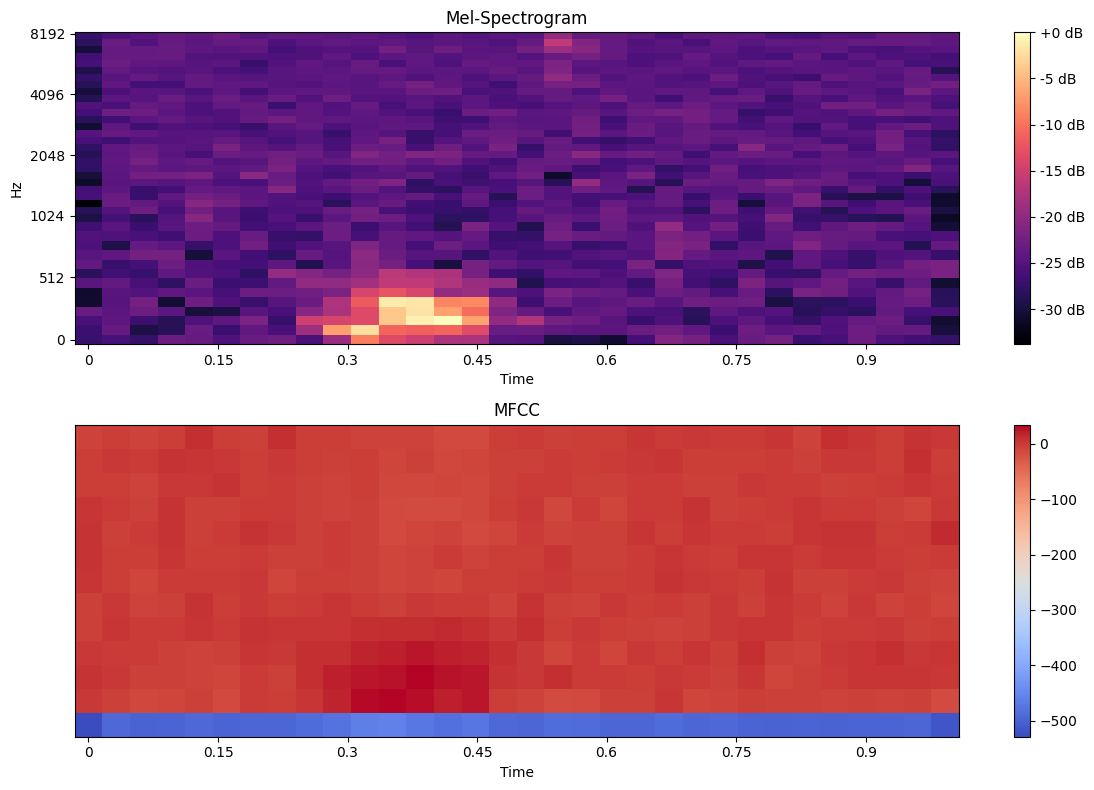

In [14]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

# === Load your audio file ===
file_path = '/capstor/scratch/cscs/ckuya/speech-data/test/audio/clip_cc5bfaea1.wav'  # Replace with your path
y, sr = librosa.load(file_path, sr=None)  # Load with original sampling rate

# === Compute Mel-spectrogram ===
mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=40, n_fft=1024, hop_length=512)
mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

# === Compute MFCC ===
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13, n_fft=1024, hop_length=512)

# === Plot both ===
plt.figure(figsize=(12, 8))

# Plot Mel-spectrogram
plt.subplot(2, 1, 1)
librosa.display.specshow(mel_spec_db, sr=sr, x_axis='time', y_axis='mel')
plt.title('Mel-Spectrogram')
plt.colorbar(format='%+2.0f dB')

# Plot MFCC
plt.subplot(2, 1, 2)
librosa.display.specshow(mfccs, sr=sr, x_axis='time')
plt.title('MFCC')
plt.colorbar()
plt.tight_layout()

plt.show()


In [1]:
import py7zr

with py7zr.SevenZipFile('/capstor/scratch/cscs/ckuya/speech-data/train.7z', mode='r') as archive:
    archive.extractall(path='/capstor/scratch/cscs/ckuya/speech-data/')


FileNotFoundError: [Errno 2] No such file or directory